## CNN 기반 지문 탐지 모델
### 개요
- 해당 모델 및 소스 코드는 CNN 기반의 오픈 소스를 바탕으로 작성되었습니다.
- 학습데이터는 오픈 된 지문 데이터 셋을 기반으로 학습합니다.
### 학습 모델 출처
#### 모델
- [학습 모델 깃 허브](https://github.com/kairess/fingerprint_recognition)
#### 데이터 셋
- [Sokoto Coventry Fingerprint Dataset (SOCOFing)](https://www.kaggle.com/ruizgara/socofing/home)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 111265279705013339
xla_global_id: -1
]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

import tensorflow as tf

# Load Dataset

(6000, 90, 90, 1) (6000, 4)


D:\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


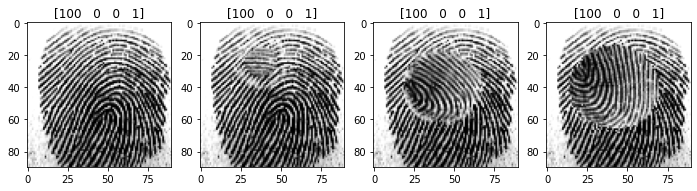

In [3]:
x_real = np.load('dataset/x_real.npz')['data']
y_real = np.load('dataset/y_real.npy')
x_easy = np.load('dataset/x_easy.npz')['data']
y_easy = np.load('dataset/y_easy.npy')
x_medium = np.load('dataset/x_medium.npz')['data']
y_medium = np.load('dataset/y_medium.npy')
x_hard = np.load('dataset/x_hard.npz')['data']
y_hard = np.load('dataset/y_hard.npy')


print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

# Train Test Split

In [4]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


# Make Label Dictionary Lookup Table

In [6]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Data Generator

In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [10]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

# Create Model

In [11]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 22, 22, 32)           9568      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 22, 22, 32)           0         ['model[0][0]',         

# Train

In [12]:
history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15


<ipython-input-12-8a04cad3d095>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)


1385/1385 [==============================] - 214s 154ms/step - loss: 0.2479 - acc: 0.8914 - val_loss: 0.0868 - val_acc: 0.9632
Epoch 2/15
1385/1385 [==============================] - 208s 150ms/step - loss: 0.1540 - acc: 0.9402 - val_loss: 0.0479 - val_acc: 0.9814
Epoch 3/15
1385/1385 [==============================] - 219s 158ms/step - loss: 0.1311 - acc: 0.9498 - val_loss: 0.0611 - val_acc: 0.9718
Epoch 4/15
1385/1385 [==============================] - 215s 155ms/step - loss: 0.1034 - acc: 0.9614 - val_loss: 0.0319 - val_acc: 0.9855
Epoch 5/15
1385/1385 [==============================] - 209s 151ms/step - loss: 0.0883 - acc: 0.9674 - val_loss: 0.0341 - val_acc: 0.9853
Epoch 6/15
1385/1385 [==============================] - 210s 151ms/step - loss: 0.0771 - acc: 0.9716 - val_loss: 0.0181 - val_acc: 0.9926
Epoch 7/15
1385/1385 [==============================] - 206s 149ms/step - loss: 0.0709 - acc: 0.9753 - val_loss: 0.0168 - val_acc: 0.9929
Epoch 8/15
1385/1385 [=======================

# Save model

In [13]:
model.save("fr_recog_model")

INFO:tensorflow:Assets written to: fr_recog_model\assets


INFO:tensorflow:Assets written to: fr_recog_model\assets
